# GNN V1

An attempt to use keras to build out a graph neural network and predict the user (label) using the dataset columns (features).

## Import and Initialize

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf

2021-07-21 13:49:57.693277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 13:49:57.693315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [22]:
zync = pd.read_csv("data/zync_session_tracking_orc_20210625_all.csv")
print(f"Zync data shape: {zync.shape}")

sizmek = pd.read_csv("data/sizmek_bidstream_raw_20210625_10k.csv")
print(f"Sizmek data shape: {sizmek.shape}")

# Fix column headers
zync.columns = [i.split(".")[1] for i in zync.columns]
sizmek.columns = [i.split(".")[1] for i in sizmek.columns]

Zync data shape: (99999, 16)
Sizmek data shape: (10000, 16)


## Transform to Graph Format
**Goal:** Achieve this format here: https://keras.io/examples/graph/gnn_citations/
- Below are some examples of the current data structures:

In [3]:
sizmek.head(1)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625


In [23]:
zync.head(3)

,session_id,client,client_id,remote_addr,referrer,user_agent_platform,user_agent_language,user_agent_browser,user_agent_string,user_agent_version,timestamp,geo_data,partner_data,session,consent_data,dt
0,042daa1a-aa73-47f0-89f4-5ead6821767e:161417230...,disqus,c3rj9u181f91uc2,128.201.40.29,https://www.biorxiv.org/content/10.1101/560755...,windows,NaN,chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,91.0.4472.114,1.624644e+09,"{""country"":""BR"",""subdivision"":""RJ"",""coordinate...",NaN,"{""clients"":{""appnexus"":null,""disqus"":""c3rj9u18...","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18
1,61abba88-212a-408c-b274-f60d0cc738c1:161770412...,sizmek,3710029932679905832,177.76.103.102,https://123963fbfc0b24fafd1fe0c9e0b835ab.safef...,windows,NaN,chrome,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,91.0.4472.114,1.624644e+09,"{""country"":""BR"",""subdivision"":""SP"",""coordinate...",NaN,"{""clients"":{""appnexus"":null,""disqus"":""c743jlde...","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18
2,bbceeddf-34a0-4d1b-916d-346ad02f0237:162464399...,sizmek,875739027850277969,87.122.112.108,https://www.intimissimi.com,iphone,NaN,webkit,Mozilla/5.0 (iPhone; CPU iPhone OS 14_6 like M...,8611,1.624644e+09,"{""country"":""DE"",""subdivision"":""HE"",""coordinate...",NaN,"{""clients"":null}","{""gdpr"":null,""gdpr_consent"":null}",2021-06-25-18


Ideally we want to get Source/Target interaction tuples. But what are the interactions in this dataset? There are no explicit sample-to-sample interactions here, it is all implicit via sample features such as URL, city, timestamp.

One thought: If two samples ARE the same user the features should match up (IP, user_agent, geo), with the exception of timestamps.

## Attempt 1: Do Some Loops
Let's create a 'connection' by looping through all rows for each row if there are any matching attribtutes in one of the select features (IP, user-agent, email, etc)

In [24]:
%%time

matching_cols = ["ip", "user_agent"]

def search_table(table, column, value):
    match_indices = []
    for ix, row in table.iterrows():
        if value == row[column]:
            match_indices.append(ix)
    print(f"Found {len(match_indices)} matches")


for ix, user_id in enumerate(sizmek["user_id"]):
    print(user_id)
    search_table(sizmek, "user_id", user_id)
    break

163543465731194
Found 9 matches
CPU times: user 320 ms, sys: 0 ns, total: 320 ms
Wall time: 317 ms


### Result: Not Good!
It appears that a single search is on the order of `O(n^2)` complexity and for just 10k rows in this sample it takes ~300ms for a single iteration. This is completely infeasable for larger sizes. But that is something that can likely be fixed later on with pre-computed hashes. I'm thinking maybe a dictionary lookup where the dictionary key is the value we are searching for, and the dictionary value is the indices where this value is located. It can simply be updated as more rows are added.

## Attempt 2: Dictionary Lookup
There is no reason I should be iterating through the entire table for each value in the table, that's what hash lookups are for! So let's create a dictionary and use that to search for the value in each table.

In [7]:
%%time

def create_dict(table, col):
    table_dict = {}
    for ix, value in enumerate(table[col]):
        #print(value)
        if value in table_dict:
            table_dict[value].append(ix)
        else:
            table_dict[value] = [ix]
    return table_dict

def search_table(table, column):
    connections = []
    lookup_dict = create_dict(table, column)
    for ix, value in enumerate(table[column]):
        if value in lookup_dict:
            for item in lookup_dict[value]:
                connections.append((ix, item, column, value))
    connections = pd.DataFrame(
        connections, 
        columns=['source', 'target', 'column', 'value']
    )
    return connections

# Create three edge lists for some features
ip_graph = search_table(sizmek, "ip")
ua_graph = search_table(sizmek, "user_agent")
zip_graph = search_table(sizmek, "zip_code")

CPU times: user 20.3 s, sys: 1.95 s, total: 22.3 s
Wall time: 22.3 s


### Result: Very Good!
I can now search the entire table for three different features in only 24 seconds, this will be much more managable to scale up in the future when using millions of rows.

In [8]:
ip_graph.sample(3)

,source,target,column,value
6331124,7344,9891,ip,71.218.146.124
15827092,9710,6369,ip,71.218.146.124
1206750,6068,8657,ip,71.218.146.124


### Example Plot of the Graph Network

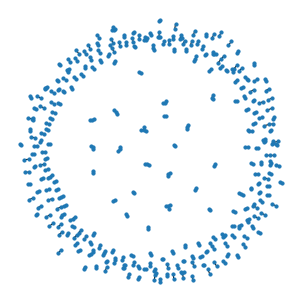

In [9]:
plt.figure(figsize=(4, 4))
g = nx.from_pandas_edgelist(zip_graph.sample(n=300))
nx.draw_spring(g, node_size=10)

## Create the Network

In [10]:
sizmek.head(2)

,user_id,household_cluster_id,zeta_user_id,account_id,url,referrer_url,city_code,state_code,zip_code,dma_code,country_code,user_agent,mobile_id,ip,server_timestamp,dt
0,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622086664,20210625
1,163543465731194,NaN,NaN,19967,http://mob.app.de.wetteronline.wetterapp,NaN,3103824.0,NaN,NaN,NaN,PL,Mozilla/5.0 (Linux; Android 11; SM-A715F Build...,b7f4d610-7879-4394-aa2b-bfb9f2b1c25b,31.0.26.0,1624622151478,20210625


In [11]:
ip_graph.head(3)

,source,target,column,value
0,0,0,ip,31.0.26.0
1,0,1,ip,31.0.26.0
2,0,2,ip,31.0.26.0


In [41]:

feature_cols = ["account_id", "url", "referrer_url", "city_code", 
                "state_code", "dma_code", "country_code"]

feature_enc = OneHotEncoder(handle_unknown="ignore")
features_df = pd.DataFrame(
    feature_enc.fit_transform(sizmek[feature_cols]).toarray(), 
    columns=feature_enc.get_feature_names(feature_cols)
)
print(f"Unique features: {features_df.shape[1]}")

label_enc = LabelEncoder()
labels = label_enc.fit_transform(sizmek["zip_code"])
print(f"Unique labels: {max(labels)}")

Unique features: 920
Unique labels: 312


In [42]:
# Edges array (sparse adjacency matrix) of shape [2, num_edges]
edges = ip_graph[["source", "target"]].to_numpy().T
# Default edge weights to 1 (we don't have any in dataset)
edge_weights = tf.ones(shape=edges.shape[1])
# Node fatures array of shape [num_nodes, num_features]
node_features = tf.cast(features_df.to_numpy(), dtype=tf.dtypes.float32)
# Create the graph info with the above features
graph_info = (node_features, edges, edge_weights)

In [43]:
from graph_network import GNNNodeClassifier, create_ffn

num_classes = len(sizmek["zip_code"].unique())

hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]).shape)

gnn_model.summary()

GNN output shape: (3, 313)
Model: "gnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Sequential)      (10000, 32)               34336     
_________________________________________________________________
graph_conv1 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
graph_conv2 (GraphConvLayer) multiple                  5888      
_________________________________________________________________
postprocess (Sequential)     (10000, 32)               2368      
_________________________________________________________________
logits (Dense)               multiple                  10329     
Total params: 58,809
Trainable params: 56,137
Non-trainable params: 2,672
_________________________________________________________________


In [86]:
split_indices = train_test_split(range(len(features_df)))

# Features split
X_train = features_df.iloc[split_indices[0], :]
X_test = features_df.iloc[split_indices[1], :]

# Labels split
y_train = labels[split_indices[0]]
y_test = labels[split_indices[1]]

X_train = np.array(split_indices[0])
y_train = pd.Series(data=y_train,index=split_indices[0])

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


history = run_experiment(gnn_model, X_train, y_train)

2021-07-21 20:26:56.909950: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-21 20:26:56.912064: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600010000 Hz


Epoch 1/300
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
enc_df

In [ ]:


x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

In [ ]:
enc_df.